<a href="https://colab.research.google.com/github/micaelleos/ia-projects-notebooks/blob/main/Decoder_pt_Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune TrOCR on the IAM Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), a collection of annotated images of handwritten text.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text.

This figure gives a good overview of the model (from the original paper):

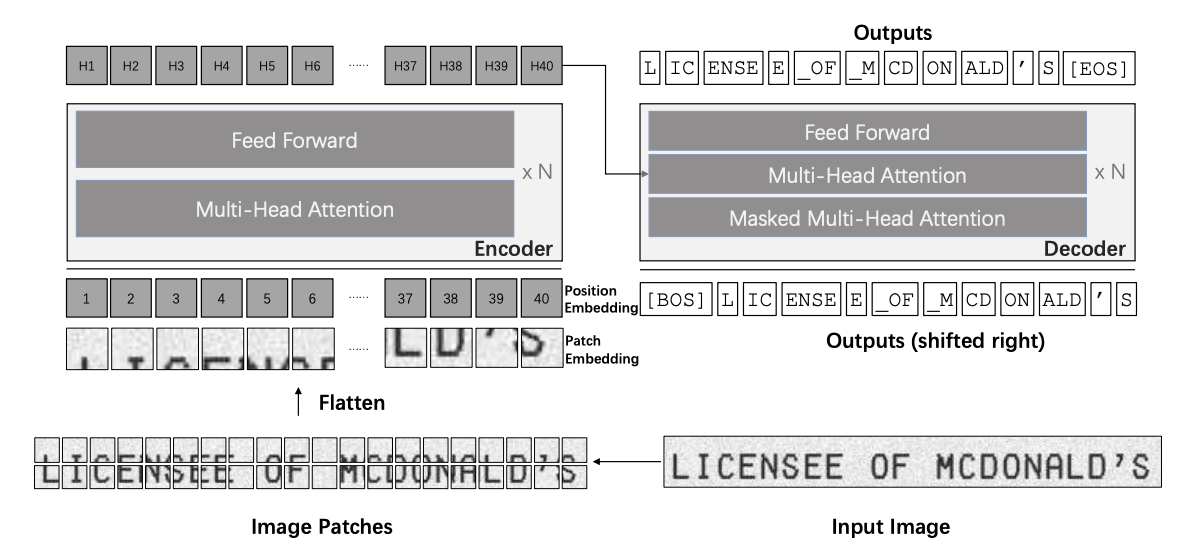

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook.

We will fine-tune the model using the Seq2SeqTrainer, which is a subclass of the 🤗 Trainer that lets you compute generative metrics such as BLEU, ROUGE, etc by doing generation (i.e. calling the `generate` method) inside the evaluation loop.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

We will not be using HuggingFace Datasets in this notebook for data preprocessing, we will just create a good old basic PyTorch Dataset.

In [3]:
!pip install -q transformers==4.45.2 sentence-transformers==3.1.1

In [4]:
!pip install -q datasets jiwer

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr).

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

### Abrindo dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = "/content/drive/MyDrive/AI/Enem/Dataset/drive"

In [7]:
import os

dirs = os.listdir(path)
img = []
txt = []
for dir in dirs:
  for file in os.listdir(path + "/" + dir):
    if file.endswith(".png"):
      img.append(f"{path}/{dir}/{file}")
    if file.endswith(".txt"):
      txt.append(f"{path}/{dir}/{file}")

In [8]:
len(txt)

3827

In [10]:
text = []
for i in txt:
  with open(i, 'r') as f:
    text.append(f.read())

In [11]:
import pandas as pd

df = pd.DataFrame(list(zip(img, text)), columns =['file_name', 'text'])
df.head()

,file_name,text
0,/content/drive/MyDrive/AI/Enem/Dataset/drive/9...,simboliza não só o poder que as ciências confe...
1,/content/drive/MyDrive/AI/Enem/Dataset/drive/9...,temas de tortura e teorias eugenistas sempre f...
2,/content/drive/MyDrive/AI/Enem/Dataset/drive/9...,"Nessa linha de raciocínio, Drummond de Andrade..."
3,/content/drive/MyDrive/AI/Enem/Dataset/drive/9...,"quais, ao mesmo tempo, levam-nos da realidade ..."
4,/content/drive/MyDrive/AI/Enem/Dataset/drive/9...,"felicidade, o prazer eterno de um mundo justal..."


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [14]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, df, processor, max_target_length=128,root_dir = ""):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [15]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [18]:
from transformers import VisionEncoderDecoderModel
from transformers import AutoTokenizer, AutoModelWithLMHead
import torch
from transformers import VisionEncoderDecoderModel, ViTModel, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("pierreguillou/gpt2-small-portuguese")
decoder = AutoModelWithLMHead.from_pretrained("pierreguillou/gpt2-small-portuguese")

tokenizer_config.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/850k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/508k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:1778: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [20]:
tokenizer

GPT2TokenizerFast(name_or_path='pierreguillou/gpt2-small-portuguese', vocab_size=50257, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [19]:
processor.tokenizer = tokenizer

In [21]:
processor

TrOCRProcessor:
- image_processor: ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: GPT2TokenizerFast(name_or_path='pierreguillou/gpt2-small-portuguese', vocab_size=50257, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

{
  "processor_class": "TrOCRProcessor"
}

In [22]:
train_dataset = CustomDataset(df=train_df,
                              processor=processor)

In [23]:
eval_dataset = CustomDataset(df=test_df,
                           processor=processor)

In [24]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3061
Number of validation examples: 766


Let's verify an example from the training dataset:

In [25]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

In [26]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [27]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

que essas enfermidades e seus sintomas - como desânimo e sonolência exacerbada, no caso da depressão - são vistos como


## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [28]:
from transformers import VisionEncoderDecoderModel

model_encoder = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encod

In [29]:
model_encoder.encoder

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivati

In [30]:
# Criar o novo modelo de OCR com encoder TrOCR + decoder GPT-2
model = VisionEncoderDecoderModel(encoder=model_encoder.encoder, decoder=decoder)

In [32]:
model_encoder

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [31]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [45]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

model.config.add_cross_attention=True
model.config.decoder_start_token_id = processor.tokenizer.bos_token

In [46]:
processor.tokenizer

GPT2TokenizerFast(name_or_path='pierreguillou/gpt2-small-portuguese', vocab_size=50257, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [47]:
processor.tokenizer.bos_token

'<|endoftext|>'

In [49]:
model.config.decoder_start_token_id

'<|endoftext|>'

In [50]:
model.config

VisionEncoderDecoderConfig {
  "add_cross_attention": true,
  "decoder": {
    "_name_or_path": "pierreguillou/gpt2-small-portuguese",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0": 0,
      "LA

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [51]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [36]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


In [37]:
import evaluate
cer_metric = evaluate.load("cer")

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [38]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
path_model = "/content/drive/MyDrive/AI/Enem/meu_modelo2"

In [ ]:
trainer.save_model(path_model)

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained(path_model)

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [ ]:
model.eval()  # Colocar em modo de inferência

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [21]:
import torch
from torch.utils.data import Dataset
from PIL import Image

id = 2
image = Image.open(df['file_name'][id]).convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model_pt.generate(pixel_values)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


ValueError: If `encoder_hidden_states` are passed, GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2SdpaAttention(
    (c_attn): Conv1D(nf=2304, nx=768)
    (c_proj): Conv1D(nf=768, nx=768)
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D(nf=3072, nx=768)
    (c_proj): Conv1D(nf=768, nx=3072)
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
) has to be instantiated with cross-attention layers by setting `config.add_cross_attention=True`

In [ ]:
df['file_name'][id], df['text'][id]

('/content/drive/MyDrive/AI/Enem/Dataset/drive/7984-038/7984-038-01-03.png',
 'por doenças mentais na sociedade brasileira mostra-se um grave problema social, uma vez que perpetua uma herança de silenciamento')

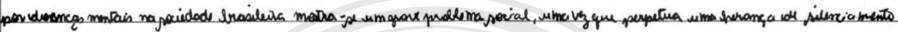

In [ ]:
image

In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("microsoft/trocr-base-handwritten")
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_text)

por doenças mentais na sociedade brasileira mostra-se um grave problema social, uma vez que perpetua uma banança de silenciamento


In [ ]:
df['text'][id]

'por doenças mentais na sociedade brasileira mostra-se um grave problema social, uma vez que perpetua uma herança de silenciamento'

In [ ]:
cer = cer_metric.compute(predictions=generated_text.split(), references=df['text'][id].split())
print(cer)

0.02702702702702703


In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [ ]:
# teste em um conjunto

texts = []

for i in range(20):
    image = Image.open(df['file_name'][i]).convert("RGB")

    # Processa a imagem e move para a GPU
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Inferência sem cálculo de gradiente
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decodificação do texto
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Adiciona ao array de resultados
    texts.append({'text_generated': generated_text, 'text_original': df['text'][i]})

    print(texts[-1])  # Exibe a última inferência feita


{'text_generated': 'so livro "memórias Póstornos de guas Cubas", hodado de Assis da "da" ao sej ao necessador-governagem ao fim que não deve filhos, e', 'text_original': 'No livro "memórias Póstumas de Bras Cubas", Machado de Assis dá voz ao narrador-personagem ao dizer que não teve filhos, e'}
{'text_generated': 'por os setores, não transtorno de iniciência Revolhamente a isso, o ideal da fragilidade que, segrega o indivíduo necessidade', 'text_original': 'por esse motivo, não transmitiu um legado de miséria. Paralelamente a isso, o ideal de fragilidade que segrega os indivíduos acometidos'}
{'text_generated': 'por doenças mentais na sociedade brasileira mostra-se um grave problema social, uma vez que perpetua uma banança de silenciamento', 'text_original': 'por doenças mentais na sociedade brasileira mostra-se um grave problema social, uma vez que perpetua uma herança de silenciamento'}
{'text_generated': 'dos vidadeções acometidos e de amença a harmonia social.', 'text_original': 'd

In [ ]:
def jaccard_similarity(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

similarity = jaccard_similarity(texts[1]['text_generated'], texts[1]['text_original'])
print(f"Similaridade de Jaccard: {similarity:.2f}")


Similaridade de Jaccard: 0.36


In [ ]:
cer_metrics = []
cer_list =[]

for i in range(20):
  max_length = max(len(texts[i]['text_generated']), len(texts[i]['text_original']))

  # Normalizar os tamanhos
  pred_text = texts[i]['text_generated'].ljust(max_length)  # Adiciona espaços à direita
  ref_text = texts[i]['text_original'].ljust(max_length)

  cer = cer_metric.compute(predictions=[pred_text], references=[ref_text])
  cer_metrics.append({'cer':cer, 'text_generated': pred_text, 'text_original': ref_text})
  cer_list.append(cer)
  print(f"CER: {cer}")


CER: 0.30327868852459017
CER: 0.34814814814814815
CER: 0.023255813953488372
CER: 0.1111111111111111
CER: 0.11382113821138211
CER: 0.06299212598425197
CER: 0.18487394957983194
CER: 0.29850746268656714
CER: 0.09821428571428571
CER: 0.25757575757575757
CER: 0.33043478260869563
CER: 0.2413793103448276
CER: 0.16666666666666666
CER: 0.09345794392523364
CER: 0.2072072072072072
CER: 0.20689655172413793
CER: 0.2558139534883721
CER: 0.1891891891891892
CER: 0.3047619047619048
CER: 0.17757009345794392


In [ ]:
sum(cer_list)/len(cer_list)

0.1987578042431796

In [ ]:
cer_metrics[3]

{'cer': 0.1111111111111111,
 'text_generated': 'dos vidadeções acometidos e de amença a harmonia social.',
 'text_original': 'dos cidadãos acometidos e de ameaça a harmonia social.  '}

In [ ]:
model2 = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
generated_ids2 = model2.generate(pixel_values)
generated_text2 = tokenizer.batch_decode(generated_ids2, skip_special_tokens=True)[0]
print(generated_text2)

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


pondesting model may inject brands, reduce you support quality point, what you prefer,


In [ ]:
cer2 = cer_metric.compute(predictions=generated_text2.split(), references=df['text'][id].split())
print(cer2)

ValueError: Mismatch in the number of predictions (13) and references (19)

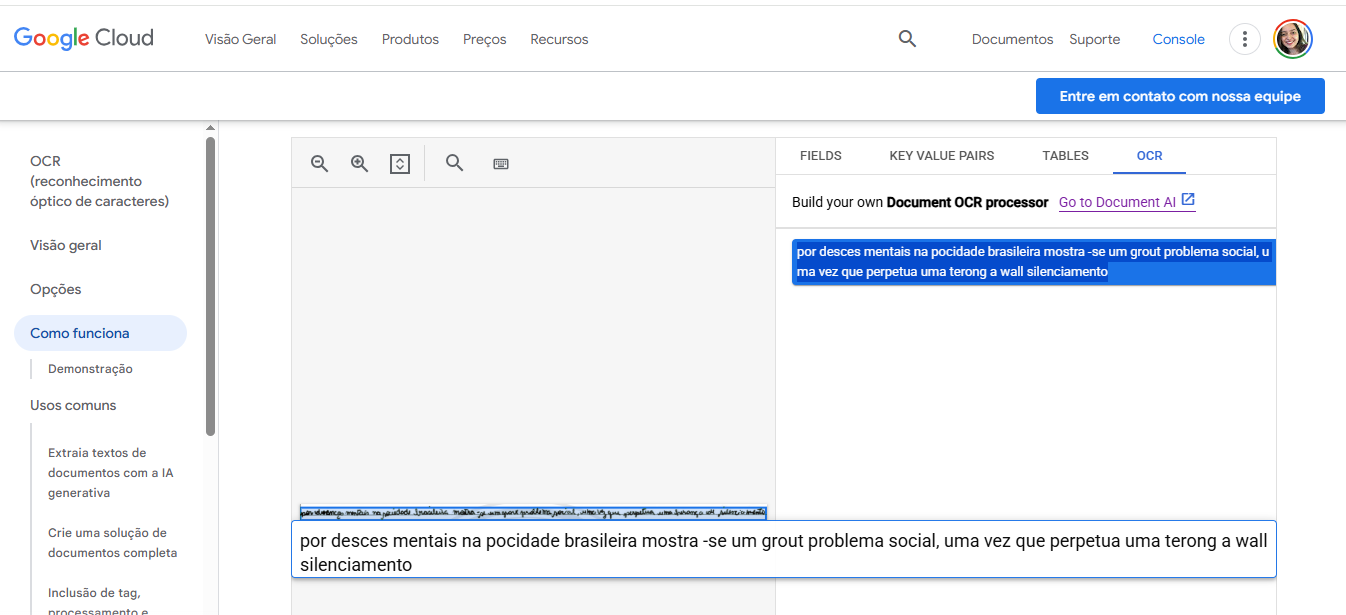

por desces mentais na pocidade brasileira mostra -se um grout problema social, uma vez que perpetua uma terong a wall silenciamento